In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, roc_curve, precision_recall_curve
)

In [ ]:
df = pd.read_csv('data.csv')

df.drop('Loan_ID', axis=1, inplace=True)

    

In [10]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [12]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

In [14]:
cat_cols = df.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

In [15]:
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [16]:
df['Income_Credit_History'] = df['ApplicantIncome'] * df['Credit_History']

In [17]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
to_scale = list(num_cols) + ['Income_Credit_History']
scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

In [20]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42)
}

In [21]:
results = {}

In [22]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'y_proba': y_proba,
        'model': model
    }


In [23]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)


In [24]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, None]
}
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

In [25]:
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_


In [26]:
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='roc_auc')
grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_

In [27]:
for name, model in [('Random Forest', best_rf), ('Gradient Boosting', best_gb)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'y_proba': y_proba,
        'model': model
    }


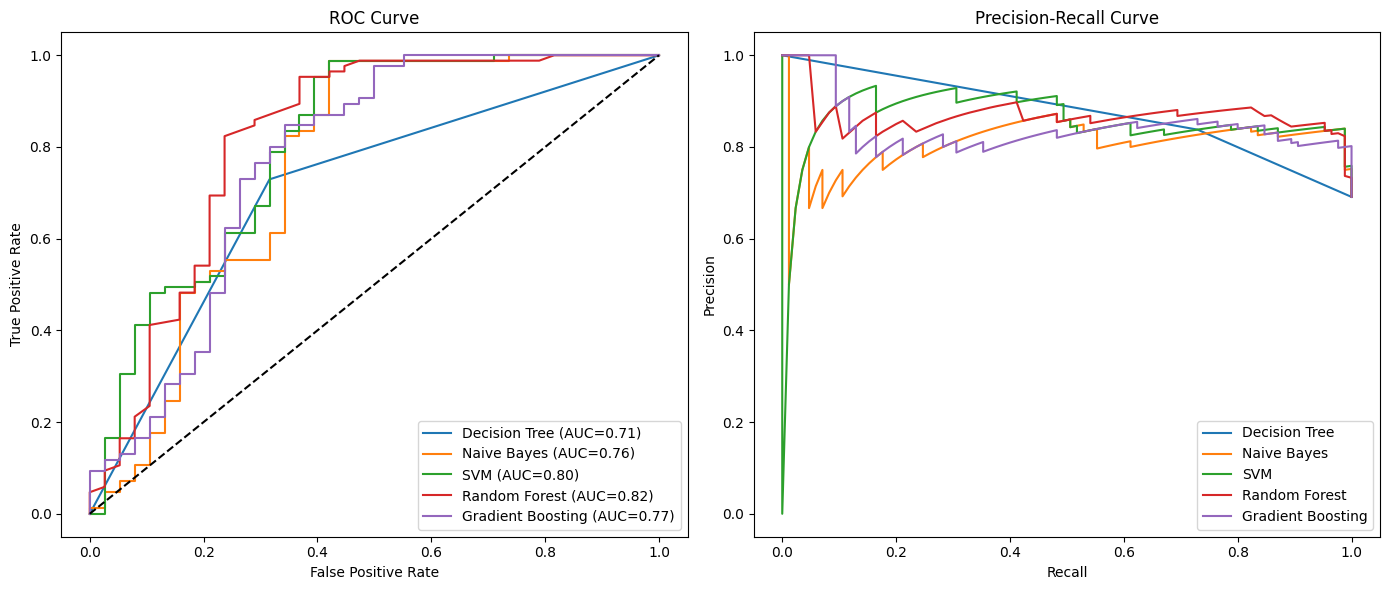

In [28]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
for name, res in results.items():
    prec, rec, _ = precision_recall_curve(y_test, res['y_proba'])
    plt.plot(rec, prec, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

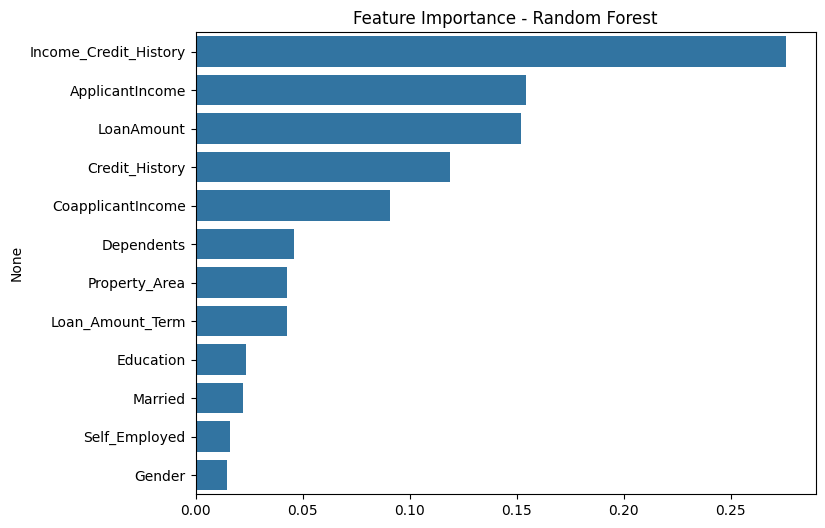

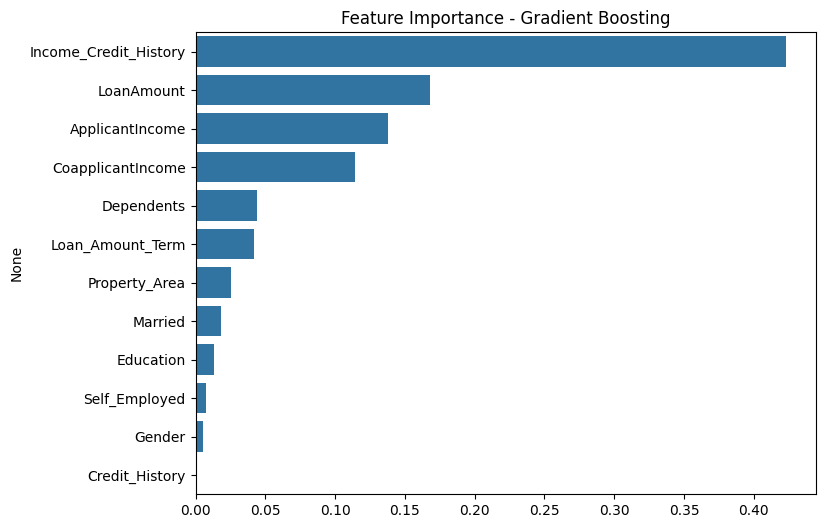

In [29]:
for name in ['Random Forest', 'Gradient Boosting']:
    model = results[name]['model']
    imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=imp.values, y=imp.index)
    plt.title(f'Feature Importance - {name}')
    plt.show()


In [ ]:
for name, res in results.items():
    print(f"{name}: Accuracy={res['accuracy']:.3f}, ROC-AUC={res['roc_auc']:.3f}, "
          f"Precision={res['precision']:.3f}, Recall={res['recall']:.3f}, F1={res['f1']:.3f}")




Model Performance Summary:
Decision Tree: Accuracy=0.715, ROC-AUC=0.707, Precision=0.838, Recall=0.729, F1=0.780
Naive Bayes: Accuracy=0.854, ROC-AUC=0.759, Precision=0.838, Recall=0.976, F1=0.902
SVM: Accuracy=0.846, ROC-AUC=0.805, Precision=0.824, Recall=0.988, F1=0.898
Random Forest: Accuracy=0.854, ROC-AUC=0.818, Precision=0.853, Recall=0.953, F1=0.900
Gradient Boosting: Accuracy=0.772, ROC-AUC=0.770, Precision=0.828, Recall=0.847, F1=0.837
